# Nengo Tests 2

https://www.nengo.ai/nengo/getting_started.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline
import os
import numpy as np
import pandas as pd
import datetime as dt
print(dt.datetime.now())

Populating the interactive namespace from numpy and matplotlib
2018-12-26 13:30:19.706052


In [3]:
import nengo
from nengo.dists import Uniform
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import tuning_curves
from nengo.utils.ensemble import sorted_neurons
from nengo.dists import Choice
from nengo.processes import Piecewise

In [4]:
from nengo.networks import Product

## Squaring the input

In [5]:
model = nengo.Network(label='Squaring Input')

In [6]:
with model:
    # Create two ensembles of leaky-integrate-and-fire neurons
    A = nengo.Ensemble(80, dimensions=1)
    B = nengo.Ensemble(100, dimensions=1)

In [7]:
# Define the squaring function
def square(x):
    return x[0] * x[0]

In [8]:
with model:
    # Create an input node that represents a sine wave
    sin = nengo.Node(np.sin)

    # Connect the input node to ensemble A
    nengo.Connection(sin, A)

    # Connection ensemble A to ensemble B
    nengo.Connection(A, B, function=square)

In [9]:
with model:
    sin_probe = nengo.Probe(sin)
    A_probe = nengo.Probe(A, synapse=0.01)
    B_probe = nengo.Probe(B, synapse=0.01)

In [10]:
# Create the simulator and run
with nengo.Simulator(model) as sim:
    sim.run(5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

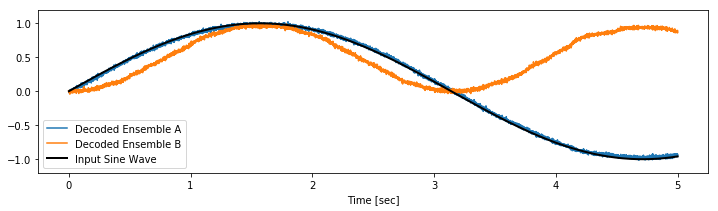

In [11]:
# Plot the input signal and decoded ensemble values
plt.figure(figsize=(12, 3))
plt.plot(
    sim.trange(), sim.data[A_probe],  label='Decoded Ensemble A')
plt.plot(
    sim.trange(), sim.data[B_probe], label='Decoded Ensemble B')
plt.plot(
    sim.trange(), sim.data[sin_probe], label='Input Sine Wave',
    color='k', linewidth=2.0)
plt.legend(loc='best')
plt.xlabel("Time [sec]")
plt.ylim(-1.2, 1.2);

## Multiplication and subnetworks

In [12]:
def prod(x):
    return x[0] * x[1]

In [13]:
def product(neuron_per_dimension, input_magnitude):
    """
    A subnetwork defined as a function for the computation of a product
    """
    model = nengo.Network(label='Product')

    with model:
        # Create passthrough nodes to redirect both inputs
        model.A = nengo.Node(output=None, size_in=1)
        model.B = nengo.Node(output=None, size_in=1)

        model.combined = nengo.Ensemble(
            neuron_per_dimension * 2,
            dimensions=2,
            radius=np.sqrt(input_magnitude**2 + input_magnitude**2),
            encoders=Choice([[1, 1], [-1, 1], [1, -1], [-1, -1]])
        )

        model.prod = nengo.Ensemble(
            neuron_per_dimension,
            dimensions=1,
            radius=input_magnitude * 2
        )

        # Connect everything up
        nengo.Connection(model.A, model.combined[0], synapse=None)
        nengo.Connection(model.B, model.combined[1], synapse=None)

        nengo.Connection(model.combined, model.prod, function=prod)

    return model

In [14]:
model = nengo.Network(label='Multiplication and Subnetworks')

In [15]:
with model:
    # Inputs
    inputA = nengo.Node(Piecewise({0: 0, 2.5: 10, 4: -10}))
    inputB = nengo.Node(Piecewise({0: 10, 1.5: 2, 3: 0, 4.5: 2}))
    
    # Input ensembles
    A = nengo.Ensemble(200, dimensions=1, radius=10)
    B = nengo.Ensemble(200, dimensions=1, radius=10)

    # Product as defined above
    prod = product(200, input_magnitude=10)

    # Connect everything up
    nengo.Connection(inputA, A)
    nengo.Connection(inputB, B)
    nengo.Connection(A, prod.A)
    nengo.Connection(B, prod.B)

    # Probes
    inputA_probe = nengo.Probe(inputA)
    inputB_probe = nengo.Probe(inputB)
    A_probe = nengo.Probe(A, synapse=0.01)
    B_probe = nengo.Probe(B, synapse=0.01)
    combined_probe = nengo.Probe(prod.combined, synapse=0.01)
    prod_probe = nengo.Probe(prod.prod, synapse=0.01)
    
    # Correct answer
    correct_ans = Piecewise({0: 0, 1.5: 0, 2.5: 20, 3: 0, 4: 0, 4.5: -20})

In [16]:
# Create the simulator and run
with nengo.Simulator(model) as sim:
    sim.run(5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

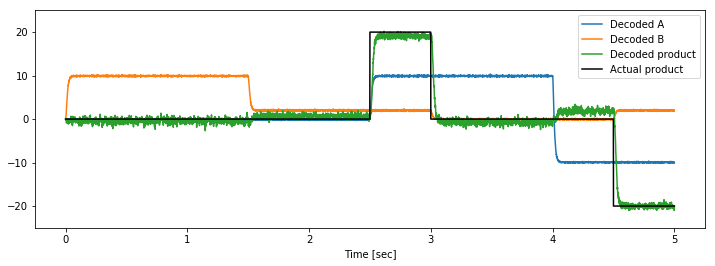

In [17]:
# Plot the input signals and decoded ensemble values
plt.figure(figsize=(12, 4))
plt.plot(
    sim.trange(), sim.data[A_probe], label="Decoded A")
plt.plot(
    sim.trange(), sim.data[B_probe], label="Decoded B")
plt.plot(
    sim.trange(), sim.data[prod_probe], label="Decoded product")
plt.plot(
    sim.trange(), correct_ans.run(sim.time, dt=sim.dt),
    c='k', label="Actual product")
plt.legend(loc='best')
plt.xlabel("Time [sec]")
plt.ylim(-25, 25);

In [18]:
# Or use prebuilt network nengo.networks.Product
model = nengo.Network(label='Multiplication and Subnetworks Prebuilt')

In [19]:
with model:
    # Inputs
    inputA = nengo.Node(Piecewise({0: 0, 2.5: 10, 4: -10}))
    inputB = nengo.Node(Piecewise({0: 10, 1.5: 2, 3: 0, 4.5: 2}))
    
    # Input ensembles
    A = nengo.Ensemble(200, dimensions=1, radius=10)
    B = nengo.Ensemble(200, dimensions=1, radius=10)

    # Product as defined by nengo
    prod = Product(400, dimensions=1, input_magnitude=10 / np.sqrt(2))

    # Connect everything up
    nengo.Connection(inputA, A)
    nengo.Connection(inputB, B)
    nengo.Connection(A, prod.input_a)
    nengo.Connection(B, prod.input_b)

    # Probes
    inputA_probe = nengo.Probe(inputA)
    inputB_probe = nengo.Probe(inputB)
    A_probe = nengo.Probe(A, synapse=0.01)
    B_probe = nengo.Probe(B, synapse=0.01)
    prod_probe = nengo.Probe(prod.output, synapse=0.01)
    
    # Correct answer
    correct_ans = Piecewise({0: 0, 1.5: 0, 2.5: 20, 3: 0, 4: 0, 4.5: -20})

In [20]:
# Create the simulator and run
with nengo.Simulator(model) as sim:
    sim.run(5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

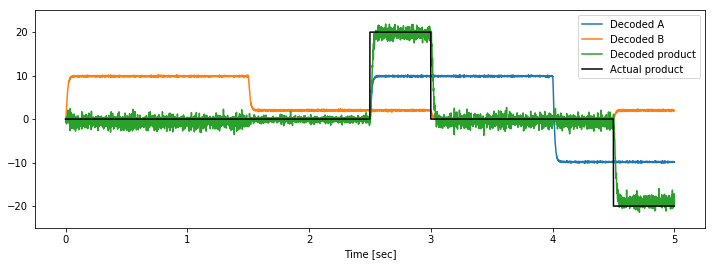

In [21]:
# Plot the input signals and decoded ensemble values
plt.figure(figsize=(12, 4))
plt.plot(
    sim.trange(), sim.data[A_probe], label="Decoded A")
plt.plot(
    sim.trange(), sim.data[B_probe], label="Decoded B")
plt.plot(
    sim.trange(), sim.data[prod_probe], label="Decoded product")
plt.plot(
    sim.trange(), correct_ans.run(sim.time, dt=sim.dt),
    c='k', label="Actual product")
plt.legend(loc='best')
plt.xlabel("Time [sec]")
plt.ylim(-25, 25);